In [1]:
import re
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

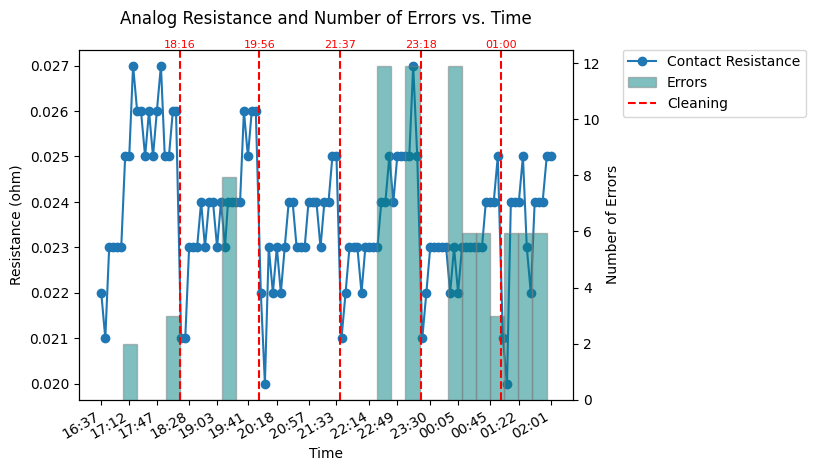

In [47]:
#open file
with open('/nfshome/natpenn/Desktop/CROCv2-iter2/wafer_N61F26-15F3_20240412_163717.log', 'r') as file:
    log_content = file.readlines()

#Set up patterns
waferpattern = r'Wafer: (\w\w\w\w)'
waferid = ""
testabortpattern = r'Testing has been aborted for chip (.*)'
failedtestchips = []
pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| ChipTester \(\S\S\S\S\-(\w\w\)) \| ERROR    \| (.*)'
nochippattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| .* \((\S\S\S\S).*\| ERROR    \| (.*)'
errtimestamps = []

#Find errors, names of aborted chips, and wafer ID
chip = ()
errors1 = ()
errors = []
nochiperror = ()
nochiperrors = []
for line in log_content:
    match = re.search(pattern, line)
    nochipmatch = re.search(nochippattern, line)
    if match:
        chip = str(match.group(2)) 
        chip = chip.replace(")","")
        errors1 = match.group(3) 
        errors.append(chip+errors1)
        testabortmatch = re.search(testabortpattern, line)
        errtimestamps.append(match.group(1))
        if testabortmatch:
            failedtestchips.append(testabortmatch.group(1))
    elif nochipmatch:
        if nochipmatch.group(3) != "Waferprobing has been aborted!":
            errors.append("AA" + nochipmatch.group(3))
            errtimestamps.append(match.group(1))
    wafermatch = re.search(waferpattern, line)
    if wafermatch:
        waferid = str(wafermatch.group(1))

errdates = [datetime.strptime(f'{ts}', '%Y-%m-%d %H:%M:%S,%f') for ts in errtimestamps]

# Plot line plot and histogram
fig, ax_line = plt.subplots()  # Axes for line plot
ax_hist = ax_line.twinx()
ax_line.plot(dates, resistances, marker='o', linestyle='-', label = 'Contact Resistance')
plt.hist(errdates, bins=30, edgecolor="grey", color="teal", density=True, alpha=0.5, label='Errors')
  
# Add vertical lines for cleaning times
for time in times:
    time_dt = datetime.strptime(f'{time}', '%Y-%m-%d %H:%M:%S,%f')
    hour_minute = time_dt.strftime('%H:%M')
    plt.axvline(x=time_dt, color='r', linestyle='--')
    plt.text(time_dt, plt.gca().get_ylim()[1], hour_minute, ha='center', va='bottom', color='r', fontsize=8)

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gcf().autofmt_xdate()

# Set labels and title
ax_line.set_xlabel('Time')
ax_line.set_ylabel('Resistance (ohm)')
ax_line.set_title('Analog Resistance and Number of Errors vs. Time', y=1.05)
ax_hist.set_ylabel('Number of Errors')

# Get 16 evenly spaced indices from the dates list
indices = np.linspace(0, len(dates) - 1, num=16, dtype=int)

# Use the indices to get the corresponding dates and set them as tick locations and labels
plt.xticks([dates[i] for i in indices], [dates[i].strftime('%H:%M') for i in indices])

#Tight layout
fig.tight_layout()

#Display legend
plt.plot([], linestyle='--', color='r', label='Cleaning')
handles, labels = [], []
for ax in [ax_line, ax_hist]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
ax_line.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.1, 1), borderaxespad=0.)

# Show plot
plt.show()